In [134]:
%pylab inline
from analysis_toolbox import *
from qualityBaseline import *
import pandas as pd 

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [135]:
bb_info = pd.read_csv('../../crowd-seg/analysis/computed_my_COCO_BBvals.csv')
obj_sorted_tbl =  bb_info[bb_info['Jaccard [COCO]']!=-1][bb_info['Jaccard [COCO]']!=0][bb_info['Jaccard [Self]']!=0].sort('object_id')
object_id_lst  = list(set(obj_sorted_tbl.object_id))

for objid in object_id_lst:

    # Ji_tbl (bb_info) is the set of all workers that annotated object i 
    bb_objects  = obj_sorted_tbl[obj_sorted_tbl["object_id"]==objid]

In [136]:
xylocs = [list(zip(*process_raw_locs([x,y]))) for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]

In [137]:
polygon_lst = []
for xyloc in xylocs:
    polygon_lst.append(Polygon(xyloc))

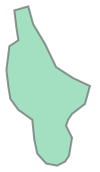

In [138]:
Polygon(xyloc)

In [139]:
from shapely.geometry import MultiPolygon

In [140]:
Ji_polygons = MultiPolygon(polygon_lst)
Ji_polygons_buffered = Ji_polygons.buffer(0.001)

In [141]:
img_info,object_tbl,bb_info,hit_info = load_info()

In [155]:
# T = total number of tasks
# n = number of points in bounding box
# m = number of metric functions of interest
# W = total number of workers 
#metric functions of interest 
#metrics_lst = ['Precision [COCO]','Recall [COCO]','Jaccard [COCO]',"NME [COCO]","Num Points",\
#               'Precision [Self]','Recall [Self]','Jaccard [Self]',"NME [Self]","Area Ratio"]
metrics_lst = ['Precision [COCO]']
worker_lst = unique(bb_info.worker_id)
#Parameters: Priors
beta = 1
gamma = 1
theta = 1
# Hidden variables 
m = len(metrics_lst)
T = len(img_info)
W = len(worker_lst)
z = np.ones((50,T))# n x T
D = np.zeros((m,T))# m x T
b = np.zeros((m,W))# m x W
c = np.zeros((m,W))# m x W

In [156]:
def abslogN(param):
    '''
    Drawing from normal distribution with prior (std) as param, with mean centered at 0
    log without nan; nan if value <0
    '''
    return log(abs(random.normal(0,param)))

In [157]:
def compute_phii(metric):
    '''
    phi value compared to ground truth 
    '''
    if metric in ['Precision [COCO]','Recall [COCO]','Jaccard [COCO]',"NME [COCO]",\
       'Precision [Self]','Recall [Self]','Jaccard [Self]',"NME [Self]"]:
        return 1
    elif metric in ["Num Points","Area Ratio"]:
        return 0

In [158]:
beta,gamma,theta = [1,1,1]

In [159]:
def Q(params):
    beta,gamma,theta = params
    w1=0.5
    w2=0.5
    loglikelihood=[]
    # Loop through all metrics 
    for k in range(m):
        #Loop through all task
        logpD_lst =[]
        for j in range(W):
            logpD_lst.append(abslogN(theta))
        logpD =sum(logpD_lst)
        #Loop through all workers
        worker_quality_prob=[]
        for i in range(T):
            worker_quality_prob.append(abslogN(beta)+ abslogN(gamma))
            logphiij_lst = []
            # Ji is the list of workers that annotated object i
            Ji = list(obj_sorted_tbl[obj_sorted_tbl["object_id"]==i].worker_id)
            for j in Ji : 
                j = int(np.where(worker_lst==j)[0])
                phii=compute_phii(metrics_lst[k])
                mu = phii-b[k][j]
                sig = sqrt(w1*D[k][i]**2+w2*c[k][j]**2)
                if sig==0: sig=1e-5
                logphiij_lst.append(log(abs(random.normal(mu,sig))))
        logphiij = sum(logphiij_lst)
        loglikelihood.append(sum(worker_quality_prob)+logphiij+logpD)
    # sum of likelihood over all the Phi functions 
    return -sum(loglikelihood)

In [160]:
from scipy.optimize import minimize

In the M step you maximize the posterior by minimizing the -log likelihood. Then using the maximized parameters $\theta^\prime$, update hidden var Di,bj,cj, by drawing your distribution based on those maximized parameters. zi will not be updated.

In [161]:
Q([beta,gamma,theta])

129.36194347808356

In [162]:
Q([1,1,1])

185.78038117842334

- Is our likelihood function convex? 
    - Because we don't have a closed form representation for Q, we cannot use positive eigenvalues of Hessian to test whether the function is convex or not. Need to figure out convexity using decomposition. 
- what is a sensible initial value to start? 
- are there any constraints that solutions must satisfy? 

In [169]:
results = optimize.minimize(Q,[1,1,1])

In [170]:
print results

      fun: 106.58191084707676
 hess_inv: array([[ 0.14891609,  0.82896105,  0.36014644],
       [ 0.82896105,  4.61452088,  2.00480253],
       [ 0.36014644,  2.00480253,  0.87099691]])
      jac: array([ -6.29420345e+07,  -1.70141382e+09,  -1.27779067e+09])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 197
      nit: 2
     njev: 35
   status: 2
  success: False
        x: array([ 1.00000092,  1.00000027,  1.00000089])


Plot the functional behaviour of the objective function at least see what it looks like and which region I should be searching through

contours by setting theta as constant 

In [228]:
def constant_theta(z,type='contour'):
    xlist = np.linspace(1,100)
    ylist = np.linspace(1,100)
    X, Y = np.meshgrid(xlist, ylist)
    Z = []
    for x in xlist:
        tmp = []
        for y in ylist:
            tmp.append(Q([x,y,z]))
        Z.append(tmp)

    plt.figure()
    if type=='contour':
        cp = plt.contourf(X, Y, Z)
    elif type =='heatmap' :
        cp = plt.imshow(Z,interpolation="none",extent=[1,100,1,100])
    plt.colorbar(cp)
    plt.title("theta = {}".format(z))
    plt.xlabel("beta")
    plt.ylabel("gamma")
    plt.show()

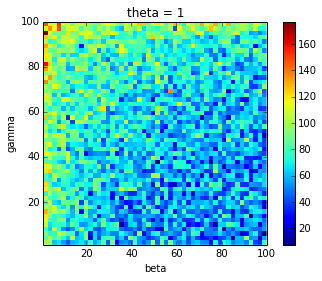

In [229]:
constant_theta(1,'heatmap')

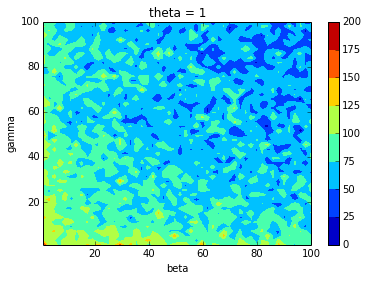

In [217]:
constant_theta(1)

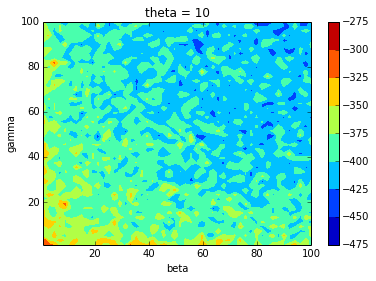

In [218]:
constant_theta(10)

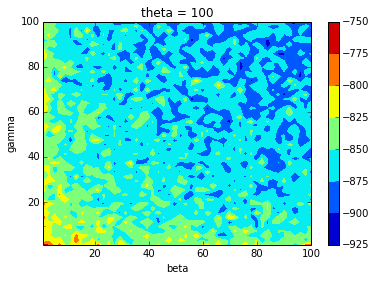

In [219]:
constant_theta(100)

In [230]:
def constant_beta(beta,type='contour'):
    xlist = np.linspace(1,100)
    ylist = np.linspace(1,100)
    X, Y = np.meshgrid(xlist, ylist)
    Z = []
    for x in xlist:
        tmp = []
        for y in ylist:
            tmp.append(Q([beta,x,y]))
        Z.append(tmp)

    plt.figure()
    if type=='contour':
        cp = plt.contourf(X, Y, Z)
    elif type =='heatmap' :
        cp = plt.imshow(Z,interpolation="none",extent=[1,100,1,100])
    plt.colorbar(cp)
    plt.title("beta = {}".format(beta))
    plt.xlabel("gamma")
    plt.ylabel("theta")
    plt.show()

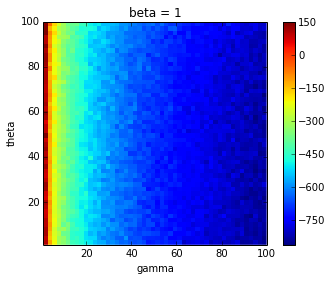

In [231]:
constant_beta(1,'heatmap')

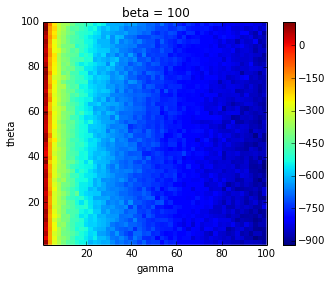

In [232]:
constant_beta(100,'heatmap')

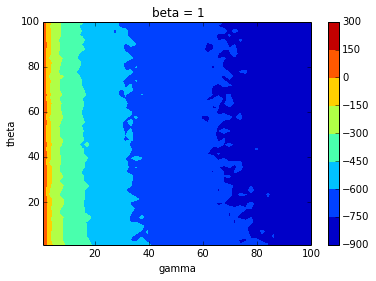

In [221]:
constant_beta(1)

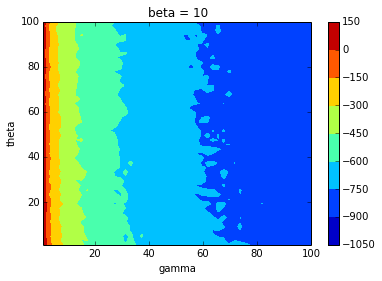

In [222]:
constant_beta(10)

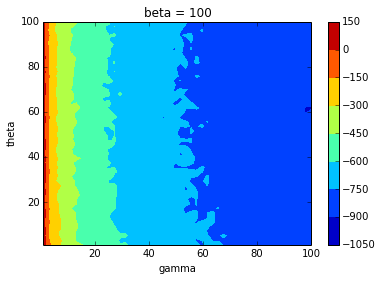

In [223]:
constant_beta(100)

In [243]:
def constant_gamma(gamma,type='contour',xlim =[1,100],ylim=[1,100]):
    xlist = np.linspace(xlim[0],xlim[1])
    ylist = np.linspace(ylim[0],ylim[1])
    X, Y = np.meshgrid(xlist, ylist)
    Z = []
    for x in xlist:
        tmp = []
        for y in ylist:
            tmp.append(Q([x,gamma,y]))
        Z.append(tmp)

    plt.figure()
    if type=='contour':
        cp = plt.contourf(X, Y, Z)
    elif type =='heatmap' :
        cp = plt.imshow(Z,interpolation="none",extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.colorbar(cp)
    plt.title("gamma = {}".format(gamma))
    plt.xlabel("beta")
    plt.ylabel("theta")
    plt.show()

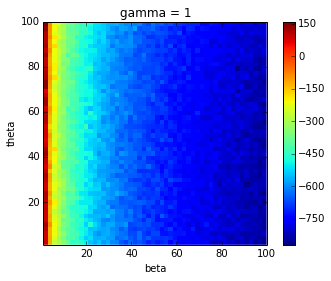

In [237]:
constant_gamma(1,'heatmap')

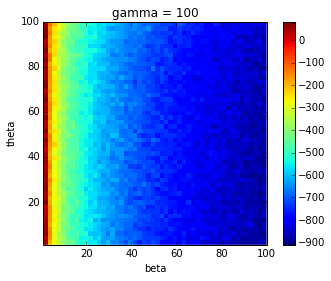

In [238]:
constant_gamma(100,'heatmap')

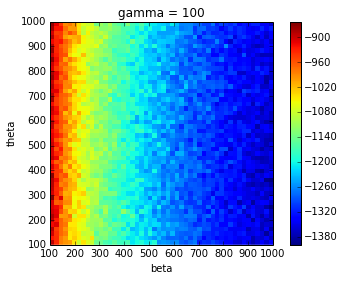

In [244]:
constant_gamma(100,'heatmap',xlim=[100,1000],ylim=[100,1000])

constant gamma and beta yields a gradient heatmap, this makes sense because the summation over j is on the outside, and within the same strip there's still some variation because we are drawing randomly not absolute. 

- The plot tells us that beta and gamma should be large in the initial conditions 
- constrain optimization so that the parameters > 0

technically, what we have is a bound and not a constraint

In [266]:
bnds= ((0, None), (0, None),(0, None))
results = optimize.minimize(Q,[200,200,200],method='tnc',bounds=bnds)#, options={'factr' : 1e7})

In [268]:
results

     fun: -1063.9628236035308
     jac: array([  3.30917087e+08,   1.00457427e+09,  -5.12528124e+08])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 3
     nit: 1
  status: 2
 success: True
       x: array([ 199.99999985,  199.99999958,  199.99999982])

this is a bit weird because the optimized parameters are always very close to the initial conditions 

In [ ]:
bnds= ((0, None), (0, None),(0, None))
N_iter = 50 #numebr of iterations 
negloglikelihood_lst = []
for i in range(N_iter): 
    # E step 
    negloglikelihood = Q([beta,gamma,theta])
    negloglikelihood_lst.append()
    # M step
    results = optimize.minimize(Q,[200,200,200],method='tnc',bounds=bnds)#, options={'factr' : 1e7})